In [1]:
import numpy as np
import squigglepy as sq
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from pprint import pprint
from datetime import datetime, timedelta


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)


def run_model(model, index_date=O3_LAUNCH_DATE):
    samples = sq.sample(model, n=100_000, verbose=True)
    pprint(sq.get_percentiles(samples, digits=0))
    print('\n-\n')
    samples_ = sq.get_percentiles(samples_to_date(samples, index_date=index_date))
    samples_ = {k: v.strftime("%Y %b %d") for k, v in samples_.items()}
    pprint(samples_)
    return samples


def samples_to_date(samples, index_date=O3_LAUNCH_DATE):
    date_converter = np.vectorize(lambda x: index_date + timedelta(days=int(np.ceil(x))))
    return date_converter(samples)

print('Loaded libraries')

Loaded libraries


In [2]:

def calculate_doubling_time(start_task_length, agi_task_length, doubling_time, acceleration=1):
    """
    Parameters
    ----------
    start_task_length : scalar or distribution
        Current hours needed for the reference task.
    agi_task_length : scalar or distribution
        Hours required for the task at AGI.
    initial_doubling_time : scalar or distribution (days)
        Doubling time at the *current* capability level.
    acceleration : scalar or distribution
        Multiplicative factor applied to the doubling time *after every doubling*.
        • 1.0  → constant exponential growth (baseline).
        • <1.0 → doubling time shrinks, giving super‑exponential growth.
        • >1.0 → growth slows over time.
    """
    doublings_needed = sq.dist_log(agi_task_length / start_task_length) / np.log(2)
    if acceleration == 1:
        return doublings_needed * doubling_time
    else:
        return doubling_time * (1 - acceleration**doublings_needed) / (1 - acceleration)

In [3]:
from datetime import datetime, timedelta

def _pretty_time(hours: float) -> str:
    """Return a string with value + unit, choosing h / min / s."""
    if hours >= 1:
        return f"{hours:6.2f}hr"
    minutes = hours * 60
    if minutes >= 1:
        return f"{minutes:6.2f}min"
    seconds = minutes * 60
    return f"{seconds:6.0f}sec"

def test_acceleration(
    start_task_length: float,
    agi_task_length: float,
    initial_doubling_time: float,
    acceleration: float = 1.0,
    start_date: str | datetime | None = None,
    date_fmt: str = "%Y‑%m‑%d",
):
    # Anchor date
    if start_date is None:
        start_date = datetime.today()
    elif isinstance(start_date, str):
        start_date = datetime.fromisoformat(start_date)

    current_task = start_task_length
    days_elapsed = 0.0
    tau = initial_doubling_time
    step = 0

    header = f"{'Step':>4} | {'Date':^10} | {'Day':>6} | {'Task':>10} | τ (d)"
    print(header)
    print("-" * len(header))

    while current_task < agi_task_length:
        date = start_date + timedelta(days=days_elapsed)
        print(f"{step:4d} | {date.strftime(date_fmt)} | "
              f"{int(days_elapsed):6d} | {_pretty_time(current_task):>10} | {tau:5.1f}")

        current_task *= 2            # actual doubling
        days_elapsed += tau
        tau *= acceleration          # super‑/sub‑exponential effect
        step += 1

    # final line after exceeding target
    date = start_date + timedelta(days=days_elapsed)
    print(f"{step:4d} | {date.strftime(date_fmt)} | "
          f"{int(days_elapsed):6d} | {_pretty_time(current_task):>10} | {tau:5.1f}  <-- reached target")


test_acceleration(
    start_task_length=2/60/60, # GPT2
    agi_task_length=167, 
    initial_doubling_time=260,
    acceleration=0.95,
    start_date="2019-02-14", # GPT2
)

Step |    Date    |    Day |       Task | τ (d)
-----------------------------------------------
   0 | 2019‑02‑14 |      0 |       2sec | 260.0
   1 | 2019‑11‑01 |    260 |       4sec | 247.0
   2 | 2020‑07‑05 |    507 |       8sec | 234.6
   3 | 2021‑02‑24 |    741 |      16sec | 222.9
   4 | 2021‑10‑05 |    964 |      32sec | 211.8
   5 | 2022‑05‑05 |   1176 |    1.07min | 201.2
   6 | 2022‑11‑22 |   1377 |    2.13min | 191.1
   7 | 2023‑06‑01 |   1568 |    4.27min | 181.6
   8 | 2023‑11‑30 |   1750 |    8.53min | 172.5
   9 | 2024‑05‑20 |   1922 |   17.07min | 163.9
  10 | 2024‑10‑31 |   2086 |   34.13min | 155.7
  11 | 2025‑04‑05 |   2242 |     1.14hr | 147.9
  12 | 2025‑08‑31 |   2390 |     2.28hr | 140.5
  13 | 2026‑01‑18 |   2530 |     4.55hr | 133.5
  14 | 2026‑06‑01 |   2664 |     9.10hr | 126.8
  15 | 2026‑10‑05 |   2790 |    18.20hr | 120.5
  16 | 2027‑02‑03 |   2911 |    36.41hr | 114.4
  17 | 2027‑05‑28 |   3025 |    72.82hr | 108.7
  18 | 2027‑09‑14 |   3134 |   145.64hr 

In [4]:
print('Fast model')
print(samples_to_date(calculate_doubling_time(start_task_length=7.57, agi_task_length=167, doubling_time=118, acceleration=0.95) @ 1))
print('-')
print('Slow model')
print(samples_to_date(calculate_doubling_time(start_task_length=5/60/60, agi_task_length=4000, doubling_time=400, acceleration=1) @ 1))
print('-')

Fast model
2026-08-12 00:00:00
-
Slow model
2048-10-16 00:00:00
-


In [5]:
def metr_model():
    days = calculate_doubling_time(start_task_length=1, agi_task_length=167, doubling_time=212, acceleration=1) # Variables from METR paper
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add easurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model, index_date=CLAUDE_3P7_LAUNCH_DATE) # Results should look similar to Figure 12

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12892.91it/s]


{1: 1102,
 5: 1252,
 10: 1343,
 20: 1463,
 30: 1553,
 40: 1637,
 50: 1718,
 60: 1803,
 70: 1897,
 80: 2017,
 90: 2193,
 95: 2351,
 99: 2670}

-

{1: '2028 Mar 02',
 5: '2028 Jul 31',
 10: '2028 Oct 30',
 20: '2029 Feb 26',
 30: '2029 May 28',
 40: '2029 Aug 19',
 50: '2029 Nov 09',
 60: '2030 Feb 01',
 70: '2030 May 06',
 80: '2030 Sep 04',
 90: '2031 Feb 27',
 95: '2031 Aug 03',
 99: '2032 Jun 18'}


In [6]:
def metr_model_with_o3():
    days = calculate_doubling_time(start_task_length=1.75, agi_task_length=167, doubling_time=118, acceleration=1) # Use o3 task length, o3 launch date, and the 2024-2025 doubling time
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model_with_o3, index_date=O3_LAUNCH_DATE)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12674.28it/s]


{1: 546,
 5: 621,
 10: 665,
 20: 723,
 30: 769,
 40: 810,
 50: 850,
 60: 892,
 70: 940,
 80: 999,
 90: 1087,
 95: 1164,
 99: 1324}

-

{1: '2026 Oct 14',
 5: '2026 Dec 28',
 10: '2027 Feb 10',
 20: '2027 Apr 10',
 30: '2027 May 25',
 40: '2027 Jul 05',
 50: '2027 Aug 15',
 60: '2027 Sep 26',
 70: '2027 Nov 12',
 80: '2028 Jan 10',
 90: '2028 Apr 08',
 95: '2028 Jun 23',
 99: '2028 Dec 01'}


In [7]:
print('## START task length (displayed in min) ##')
current_best = 1.75 # o3 task length at 50% reliability?

reliability_needed = sq.mixture([[0.3, 0.5], # What amount of reliability will we need? Probability distribution over hypotheses
                                 [0.4, 0.8],
                                 [0.2, 0.9],
                                 [0.1, 0.99]])

def reliability_count_to_penalty(reliability):
    r = np.asarray(reliability, dtype=float)
    reliability = np.array([0.50, 0.80, 0.90, 0.95, 0.99])
    penalty = np.array([1.0, 0.25, 0.25**2, 0.25**3, 0.25**4])
    matches = r[..., None] == reliability
    hit_any = matches.any(axis=-1)
    idx = matches.argmax(axis=-1)
    out = np.full_like(r, np.nan, dtype=float)
    out[hit_any] = penalty[idx[hit_any]]
    return out

task_type_penalty = sq.mixture([[0.2, 1],                         # 20% chance that METR's software tasks are sufficient for AGI
                                [0.4, 1 / sq.lognorm(5, 20)],     # 40% chance that true AGI tasks are 5-20x harder than METR's software tasks
                                [0.4, 1 / sq.lognorm(10, 1000)]]) # 40% chance that true AGI tasks are 10-1000x harder than METR's software tasks

# Start with current best, add reliability penalty
start_task_length = current_best * sq.dist_fn(reliability_needed, reliability_count_to_penalty)

# Add task type penalty
start_task_length *= task_type_penalty

# Add a minimum value of 30sec
start_task_length = sq.dist_max(30/60/60, start_task_length)

# Show samples in minutes (naturally in hours)
sq.get_percentiles((start_task_length * 60) @ 100_000, digits=1)

## START task length (displayed in min) ##


{1: 0.5,
 5: 0.5,
 10: 0.5,
 20: 0.5,
 30: 0.5,
 40: 0.7,
 50: 1.6,
 60: 2.9,
 70: 6.5,
 80: 11.0,
 90: 26.2,
 95: 105.0,
 99: 105.0}

In [8]:
print('## AGI task length (displayed in hrs) ##')
agi_task_length = sq.lognorm(40, 2000, credibility=80, lclip=40)
sq.get_percentiles(agi_task_length @ 100_000, digits=0)

## AGI task length (displayed in hrs) ##


{1: 40,
 5: 40,
 10: 40,
 20: 78,
 30: 126,
 40: 190,
 50: 279,
 60: 413,
 70: 629,
 80: 1023,
 90: 2000,
 95: 3477,
 99: 9612}

In [9]:
print('## DOUBLING TIME (displayed in days) ##')
doubling_time = sq.lognorm(90, 250, credibility=80, lclip=60)
sq.get_percentiles(doubling_time @ 100_000, digits=0)

## DOUBLING TIME (displayed in days) ##


{1: 60,
 5: 78,
 10: 90,
 20: 108,
 30: 122,
 40: 136,
 50: 150,
 60: 166,
 70: 185,
 80: 210,
 90: 251,
 95: 289,
 99: 380}

In [10]:
print('## ACCELERATION (displayed in days)')
acceleration = sq.norm(0.95, 1.02, credibility=80)
sq.get_percentiles(acceleration @ 100_000, digits=3)

## ACCELERATION (displayed in days)


{1: 0.922,
 5: 0.94,
 10: 0.95,
 20: 0.962,
 30: 0.971,
 40: 0.978,
 50: 0.985,
 60: 0.992,
 70: 0.999,
 80: 1.008,
 90: 1.02,
 95: 1.03,
 99: 1.049}

In [11]:
print('## SHIFT (displayed in days) ##')
shift = sq.norm(30, 30*5, credibility=80, lclip=0)
sq.get_percentiles(shift @ 100_000, digits=0)

## SHIFT (displayed in days) ##


{1: 0,
 5: 13,
 10: 30,
 20: 51,
 30: 66,
 40: 78,
 50: 90,
 60: 102,
 70: 115,
 80: 130,
 90: 150,
 95: 167,
 99: 199}

In [12]:
def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time, acceleration)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add easurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:04<00:00, 1559.76it/s]


{1: 528,
 5: 797,
 10: 982,
 20: 1254,
 30: 1488,
 40: 1720,
 50: 1963,
 60: 2234,
 70: 2567,
 80: 3017,
 90: 3764,
 95: 4479,
 99: 6240}

-

{1: '2026 Sep 26',
 5: '2027 Jun 22',
 10: '2027 Dec 24',
 20: '2028 Sep 21',
 30: '2029 May 14',
 40: '2029 Dec 31',
 50: '2030 Aug 31',
 60: '2031 May 30',
 70: '2032 Apr 26',
 80: '2033 Jul 20',
 90: '2035 Aug 07',
 95: '2037 Jul 21',
 99: '2042 May 17'}


In [13]:
print('## DISTRIBUTION OF AGI ARRIVAL DATE ##')
# Convert datetime samples to years
agi_years = [s / 365 + 2025 for s in samples]
pctiles = sq.get_percentiles(agi_years, percentiles=[1, 2, 3, 4, 5, 10, 15, 20, 25, 35, 50, 60, 75, 80, 90, 95])
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1], 1))) if o[1] < 2100 else '>2100') 
    for o in pctiles.items()
])
print('')
print('')
print('## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##')
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1] - 2025, 1))) if o[1] < 2100 else '>75') + ' years from now' 
    for o in pctiles.items()
])
print('(Mean: {} years from now)'.format(int(round(np.mean([t - 2025 for t in agi_years])))))
print('')
print('')


print('## AGI ARRIVAL DATE BY BIN ##')

def bin_agi_yrs(low=None, hi=None):
    low = 2025 if low is None else low
    if hi is None:
        r = np.mean([y >= low for y in agi_years])
    else:
        r = np.mean([(y >= low) and (y <= hi) for y in agi_years])
    return round(r * 100, 1)


year_pairs = [[2025, 2026],
              [2026, 2027],
              [2027, 2028],
              [2028, 2029],
              [2029, 2030],
              [2030, 2032],
              [2032, 2035],
              [2035, 2040],
              [2040, 2050],
              [2050, 2060],
              [2060, 2070],
              [2070, 2080],
              [2080, 2090],
              [2090, 2100]]
for y in year_pairs:
    if y[0] == y[1] - 1:
        print('{}: {}%'.format(y[0], bin_agi_yrs(y[0], y[1])))
    else:
        print('{}-{}: {}%'.format(y[0], y[1]-1, bin_agi_yrs(y[0], y[1])))
print('>{}: {}%'.format(2100, bin_agi_yrs(low=2100)))
print('')
print('')

print('## AGI ARRIVAL DATE BY YEAR ##')
for y in list(range(2025, 2035)) + list(range(2035, 2100, 5)):
    print('By EOY {}: {}%'.format(y, bin_agi_yrs(hi=y+1)))
print('')

## DISTRIBUTION OF AGI ARRIVAL DATE ##
['1%: 2026.4',
 '2%: 2026.7',
 '3%: 2026.9',
 '4%: 2027.1',
 '5%: 2027.2',
 '10%: 2027.7',
 '15%: 2028.1',
 '20%: 2028.4',
 '25%: 2028.8',
 '35%: 2029.4',
 '50%: 2030.4',
 '60%: 2031.1',
 '75%: 2032.6',
 '80%: 2033.3',
 '90%: 2035.3',
 '95%: 2037.3']


## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##
['1%: 1.4 years from now',
 '2%: 1.7 years from now',
 '3%: 1.9 years from now',
 '4%: 2.1 years from now',
 '5%: 2.2 years from now',
 '10%: 2.7 years from now',
 '15%: 3.1 years from now',
 '20%: 3.4 years from now',
 '25%: 3.8 years from now',
 '35%: 4.4 years from now',
 '50%: 5.4 years from now',
 '60%: 6.1 years from now',
 '75%: 7.6 years from now',
 '80%: 8.3 years from now',
 '90%: 10.3 years from now',
 '95%: 12.3 years from now']
(Mean: 6 years from now)


## AGI ARRIVAL DATE BY BIN ##
2025: 0.2%
2026: 3.4%
2027: 10.4%
2028: 14.7%
2029: 15.7%
2030-2031: 25.3%
2032-2034: 19.2%
2035-2039: 9.2%
2040-2049: 1.9%
2050-2059: 0.1%
2060-2069: 0.0%
20

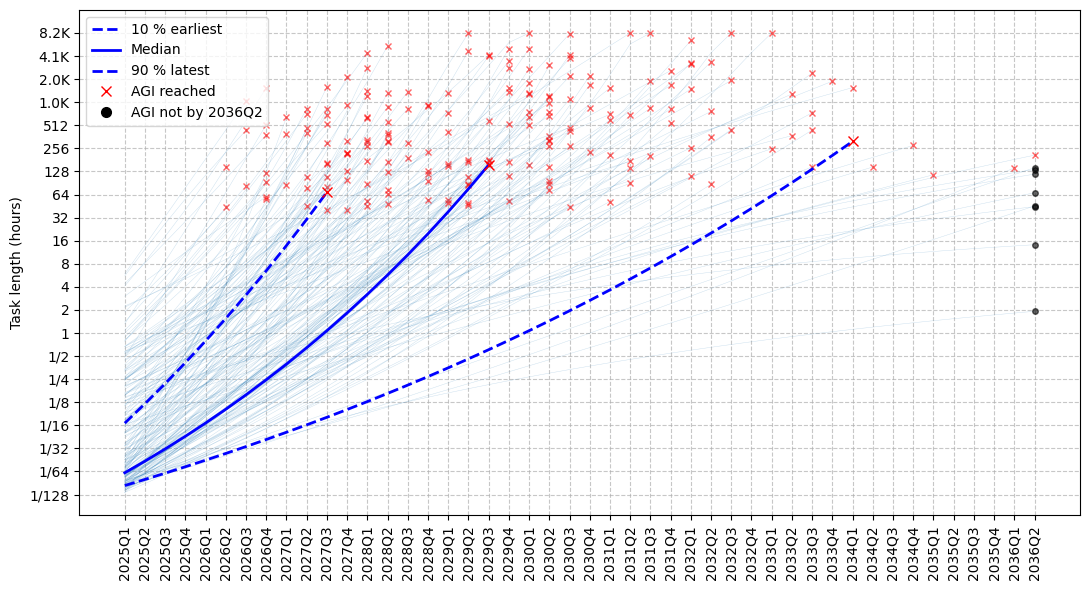

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import squigglepy as sq

DAYS_PER_QUARTER = 365 / 4


def billions_formatter(x, pos):
    if x >= 1e9:
        return f"{x/1e9:.1f}B"
    if x >= 1e6:
        return f"{x/1e6:.1f}M"
    if x >= 1e3:
        return f"{x/1e3:.1f}K"
    if x <= 0.5:
        return f"1/{1/x:.0f}"
    return f"{x:.0f}"


def _quarter_labels(n: int, start_year: int = 2025) -> list[str]:
    return [f"{start_year + q // 4}Q{q % 4 + 1}" for q in range(n + 1)]


def _y_ticks(lo: int = -7, hi: int = 13) -> list[int]:
    return [2 ** k for k in range(lo, hi + 1)]


def _first_curve(order, traj, reference, above):
    cmp = np.greater_equal if above else np.less_equal
    for idx in order:
        if np.all(cmp(traj[idx], reference)):
            return idx
    return order[0]


def plot_exponential_growth(
    doubling_time_days,
    starting_hours,
    agi_task_length,
    shift=0,
    acceleration=1,
    n_quarters: int = 40,
    n_samples: int = 10_000,
    n_traces: int = 100,
) -> None:
    tau0 = sq.sample(doubling_time_days, n=n_samples)
    accel = sq.sample(acceleration, n=n_samples)
    secret = sq.sample(shift, n=n_samples)
    agi = sq.sample(sq.dist_min(2**13, agi_task_length), n=n_samples)
    start = sq.sample(starting_hours, n=n_samples) * 2 ** (secret / tau0)

    quarters = np.arange(n_quarters + 1)
    traj = np.zeros((n_samples, len(quarters)))
    clip_idx = np.full(n_samples, len(quarters), dtype=int)

    for i in range(n_samples):
        tau = tau0[i]
        val = start[i]
        for j in range(len(quarters)):
            if val >= 2**13:
                traj[i, j:] = 2**13
                clip_idx[i] = j
                break
            traj[i, j] = val
            val *= 2 ** (DAYS_PER_QUARTER / tau)
            tau *= accel[i]

    reached = traj >= agi[:, None]
    first_hit = np.argmax(reached, axis=1)
    first_hit[np.all(~reached, axis=1)] = len(quarters)

    order = np.argsort(first_hit)
    median_idx = order[len(order) // 2]
    median_curve = traj[median_idx]

    idx10 = _first_curve(order[int(0.10 * n_samples):], traj, median_curve, above=True)
    idx90 = _first_curve(order[: int(0.90 * n_samples)][::-1], traj, median_curve, above=False)

    highlights = {
        "10 % earliest": (traj[idx10], first_hit[idx10], clip_idx[idx10], "b--"),
        "Median": (median_curve, first_hit[median_idx], clip_idx[median_idx], "b-"),
        "90 % latest": (traj[idx90], first_hit[idx90], clip_idx[idx90], "b--"),
    }

    plt.figure(figsize=(11, 6))
    rng = np.random.default_rng()

    for i in rng.choice(n_samples, min(n_traces, n_samples), replace=False):
        end_q = min(first_hit[i], clip_idx[i], len(quarters) - 1)
        plt.plot(
            quarters[: end_q + 1],
            traj[i, : end_q + 1],
            color="tab:blue",
            lw=0.3,
            alpha=0.25,
        )
        marker = "rx" if first_hit[i] < len(quarters) else "ko"
        plt.plot(quarters[end_q], traj[i, end_q], marker, ms=4, alpha=0.6)

    for label, (curve, hit_q, clip_q, style) in highlights.items():
        end_q = min(hit_q, clip_q, len(quarters) - 1)
        plt.plot(quarters[: end_q + 1], curve[: end_q + 1], style, lw=2, label=label)
        marker = "rx" if hit_q < len(quarters) else "ko"
        plt.plot(quarters[end_q], curve[end_q], marker, ms=7)

    plt.plot([], [], "rx", ms=7, label="AGI reached")
    plt.plot([], [], "ko", ms=7, label="AGI not by 2036Q2")

    plt.yscale("log", base=2)
    plt.yticks(_y_ticks())
    plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))
    plt.xticks(quarters, _quarter_labels(n_quarters), rotation=90)
    plt.grid(ls="--", alpha=0.7)
    plt.ylabel("Task length (hours)")
    plt.tight_layout()
    plt.legend(loc="upper left")
    plt.show()
    return None


plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=start_task_length,
    agi_task_length=agi_task_length,
    shift=shift,
    acceleration=acceleration,
    n_quarters=45,
    n_samples=100_000,
    n_traces=200,
)